In [1]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from astropy.time import Time
from astropy import units as u

In [2]:
def RV_fit(df,Xcol,Ycol,YErrCol,fit='Quadratic',jitter=0):
    if fit == 'Linear':
        res_wls = sm.WLS(df[Ycol], sm.add_constant(df[Xcol])
                         , weights=1./(df[YErrCol] ** 2 + jitter**2)).fit()
        return {'aRV': res_wls.params[1],
               'aRV_Err': res_wls.bse[1],
               'reduced ChiSq': (res_wls_sq.resid**2/(df[YErrCol] ** 2
                                                      + jitter**2)).sum()/(len(df)-2)}
    else:
        df[Xcol+'Sq'] = df[Xcol]**2
        res_wls = sm.WLS(df[Ycol], sm.add_constant(df[[Xcol,Xcol+'Sq']])
                         , weights=1./(df[YErrCol] ** 2 + jitter**2)).fit()
        return {'aRV': res_wls.params[1],
               'aRV_Err': res_wls.bse[1],
               'reduced ChiSq': (res_wls.resid**2/(df[YErrCol] ** 2
                                                      + jitter**2)).sum()/(len(df)-3)}
# here I add a jitter to the RV noise that makes ch-sq as close to unity as possible.
def ChiSq1_RV_fit(df,Xcol,Ycol,YErrCol,fit='Quadratic',
                  jitter_list=np.arange(0,1000,2)):
    results = pd.DataFrame(columns=['aRV','aRV_Err','reduced ChiSq'])
    for jitter in jitter_list:
        results.loc[jitter,:] = RV_fit(
            df,Xcol,Ycol,YErrCol,fit=fit,jitter=jitter)
    results['ChiSq1 diff'] = (results['reduced ChiSq'] - 1).abs()
    return results.loc[results['ChiSq1 diff']==results['ChiSq1 diff'].min(),
                  ['aRV','aRV_Err','reduced ChiSq']].iloc[0]
    

def year_to_datetime(x):
    year = int(x)
    rem = x - year
    base = datetime.datetime(year, 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base
                                               ).total_seconds() * rem)
    return result

In [3]:
radial_acc = pd.read_excel('hd_to_hip_map.xlsx').sort_values(by='hd_id')
filename = 'Full-Catalog_WDS-HIRES-New-Chisq.csv'
catalog = pd.read_csv(filename)
catalog = catalog[catalog.hip_id.isin(list(radial_acc.hip_id.unique()))].copy()
catalog['reftime'] = ((catalog.epoch_ra_gaia + catalog.epoch_dec_gaia)*3/2 + (
    catalog.epoch_ra_hip + catalog.epoch_dec_hip)/2)/4
catalog.reftime = catalog.reftime.map(year_to_datetime)
radial_acc = radial_acc.merge(catalog[['hip_id','reftime']])
radial_acc['aRV'] =0
radial_acc['aRV_Err'] =0
radial_acc['reduced ChiSq'] =0
local_appx_yr = 2
min_points = 5
min_error = 0.1

for i in radial_acc.index:
    rv_data = pd.read_csv('%s_RV.dat'%radial_acc.loc[i,'hd_id'],sep='\t').iloc[:,:3]
    rv_data.columns = ['BJD','RV','RVErr']
    rv_data['Year'] = rv_data['BJD'].apply(lambda x: (
        Time(x, format='jd').datetime - radial_acc.loc[i,'reftime']).total_seconds()/31557600)
    
    fit = ChiSq1_RV_fit(rv_data,'Year','RV','RVErr')
    if ((abs(fit['aRV_Err']/fit['aRV'])>min_error) & 
        (len(rv_data.loc[rv_data.Year.abs()<local_appx_yr,:])>=min_points)):
        radial_acc.loc[i,['aRV','aRV_Err','reduced ChiSq']] = ChiSq1_RV_fit(
            rv_data.loc[rv_data.Year.abs()<local_appx_yr,:].copy(),'Year','RV','RVErr')
        radial_acc.loc[i,'RVfit'] = 'QuadraticLocal'
    else:
        radial_acc.loc[i,['aRV','aRV_Err','reduced ChiSq']] = fit
        radial_acc.loc[i,'RVfit'] = 'Quadratic'
    #plt.figure()
    #plt.scatter(rv_data['Year'],rv_data['RV'])
    #plt.title('%s PctErr %s'%(radial_acc.loc[i,'hd_id'],np.around(
        #radial_acc.loc[i,'aRV_Err']/radial_acc.loc[i,'aRV'],decimals=2)))
    #plt.savefig(radial_acc.loc[i,'hd_id'])
    #plt.close()
    
    


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [4]:
radial_acc

,hd_id,hip_id,a,a_er_plus,a_er_min,ecc,ecc_er,c_msini_jup,c_msini_er_jup,sep_source,sep_type,reftime,aRV,aRV_Err,reduced ChiSq,RVfit
0,HD13724,10278,12.400000,2.600000,2.600000,0.3400,0.0900,26.77000,4.400000,NasaEPArchive,a,2009-07-19 05:41:20.747103,-9.803331,0.556807,1.039138,Quadratic
1,HD145825,79578,7.330000,0.200000,0.210000,0.3430,0.0090,108.00000,6.200000,Kane2019,a,2009-07-14 11:35:25.569832,58.816747,19.019423,1.007882,Quadratic
2,HD159062,85653,57.600000,0.600000,0.600000,0.0000,0.0000,675.67976,17.808614,Han2019,proj_sep,2009-08-03 19:47:20.462148,-13.856490,0.097621,0.669595,Quadratic
3,HD212330,110649,16.210000,0.480000,0.470000,0.2120,0.0080,673.00000,33.000000,Kane2019,a,2009-05-05 17:41:37.400008,455.835073,18.313266,1.003633,Quadratic
4,HD217850,113789,4.560000,0.240000,0.240000,0.7621,0.0019,21.60000,2.600000,NasaEPArchive,a,2009-07-22 07:47:24.166027,53.919552,3.206696,0.959847,QuadraticLocal
5,HD219077,114699,7.030000,0.200000,0.210000,0.7680,0.0040,13.40000,0.780000,Kane2019,a,2009-07-28 03:41:40.763492,47.423798,1.712744,0.909441,QuadraticLocal
6,HD221420,116250,18.500000,2.300000,2.300000,0.4200,0.0500,9.70000,1.100000,Kane2019,a,2009-07-23 19:44:00.682883,-11.776040,0.573055,0.877113,Quadratic
7,HD45701,30480,22.280000,0.570000,0.580000,0.1700,0.0040,1034.00000,87.000000,Kane2019,a,2009-08-04 07:36:45.593897,-215.823552,2.375629,1.023377,Quadratic
8,HD68017,40118,14.138526,0.172684,0.172684,0.0000,0.0000,129.00000,3.000000,Brandt2019,proj_sep,2009-08-09 13:01:37.250426,6.777755,0.344554,1.167627,Quadratic
9,HD72659,42030,4.750000,0.080000,0.080000,0.2200,0.0300,3.85000,0.230000,NasaEPArchive,a,2009-08-09 01:21:39.753877,70.331981,44.485115,0.877545,Quadratic


In [5]:
#Here I compute the astrometric acceleration

from f_calc_astrometric_acceleration import calc_astrometric_acceleration

def calc_astrometric_acceleration_wrapper(row):

    # for acceleration calculation and converts to Astropy units
    pmrahip = row['pmra_hip']*u.mas/u.yr #mas/yr
    pmragaia = row['pmra_gaia']*u.mas/u.yr #mas/yr
    pmrahg = row['pmra_hg']*u.mas/u.yr #mas/yr
    
    pmdechip = row['pmdec_hip']*u.mas/u.yr #mas/yr
    pmdecgaia = row['pmdec_gaia']*u.mas/u.yr #mas/yr
    pmdechg = row['pmdec_hg']*u.mas/u.yr #mas/yr

    rahipepoch = row['epoch_ra_hip']*u.yr #yr
    ragaiaepoch = row['epoch_ra_gaia']*u.yr #yr
    dechipepoch = row['epoch_dec_hip']*u.yr #yr
    decgaiaepoch = row['epoch_ra_gaia']*u.yr #yr
    
    plx = (row['parallax_gaia'])*u.mas #parallax in mas
    d = plx.to(u.parsec, equivalencies=u.parallax())
    plx_error = row['parallax_gaia_error']*u.mas
    d_error = plx_error.to(u.parsec, equivalencies=u.parallax())
    
    pmragaia_error = row['pmra_gaia_error']*u.mas/u.yr
    pmdecgaia_error = row['pmdec_gaia_error']*u.mas/u.yr
    pmrahg_error = row['pmra_hg_error']*u.mas/u.yr
    pmdechg_error = row['pmdec_hg_error']*u.mas/u.yr
    pmrahip_error = row['pmra_hip_error']*u.mas/u.yr
    pmdechip_error = row['pmdec_hip_error']*u.mas/u.yr

    error_numerator_one = (pmdecgaia - pmdechg)**2 * (pmdecgaia_error**2 
                                                      + pmdechg_error**2)
    error_denominator_one = (1/d)**2 * (((decgaiaepoch - dechipepoch)**2 
                                         + (ragaiaepoch - rahipepoch)**2)/2) * (
        (pmdecgaia - pmdechg)**2 + (pmragaia - pmrahg)**2)
    error_numerator_two = (pmragaia - pmrahg)**2 * (pmragaia_error**2 + pmrahg_error**2)
    error_denominator_two = error_denominator_one
    error_numerator_three = ((pmdecgaia - pmdechg)**2 + (pmragaia - pmrahg)**2
                            ) * (1/d_error)**2
    error_denominator_three = (1/d)**4 * (((decgaiaepoch - dechipepoch)**2 + (
        ragaiaepoch - rahipepoch)**2)/2)
    
    
    astrometric_acc_error_sq = 4*((error_numerator_one/error_denominator_one) 
                                  + (error_numerator_two/error_denominator_two) 
                                  + (error_numerator_three/error_denominator_three))
    astrometric_acc_error = np.sqrt(astrometric_acc_error_sq)
    # Acc Error
    astrometric_acc_error_cu = astrometric_acc_error.to(u.m /u.second/u.yr, equivalencies=u.dimensionless_angles())

    #calls function "f_calc_astrometric_acceleration", a script that
    #contains the acceleration calculation


    #executes the acceleration calculation function
    return [calc_astrometric_acceleration(plx,
                                      pmrahip,
                                      pmragaia,
                                      pmrahg,
                                      pmdechip,
                                      pmdecgaia,
                                      pmdechg,
                                      rahipepoch,
                                      ragaiaepoch,
                                      dechipepoch,
                                      decgaiaepoch),astrometric_acc_error_cu]

#Here I compute absolute separation from a and e using the PDF from Savransky 2011
def compute_r(row,size=10000):
    e = np.random.normal(row['ecc'],row['ecc_er'],100) #gives 100 samples from a normal 
    # distribution with mean of 'ecc' (published eccentricity) and SD of ecc_er.
    e[e<0] = 0
    e[e>1] = 1
    wts = np.zeros(1000) # create vector of 1K zeroes
    s = 0
    ta = 2*np.pi*np.arange(0,1,0.001) # discretizes true anomaly angles into 1K pts from
    # zero to 2pi
    # now we take the i'th TA angle and compute its corresponding probability using the ecc
    # samples and the PDF integration formula.
    for i in ta:
        wts[s] = np.sum((1-e**2)**1.5/(1+e*np.cos(i))**2)/(2*np.pi)
        s = s+1
    # now we have the distribution of the TA angle
    # next, we sample from distributions of a, e and TA angle to get the distribution
    # of the absolute separation
    # size is input above
    e = np.random.normal(row['ecc'],row['ecc_er'],size)
    a = np.random.normal(row['a'].value,row['a_er_plus'].value,size)
    r = np.zeros(size)
    for i in np.arange(size):
        r[i] = a[i]*(1-e[i]**2)/(1 + e[i]*np.cos(np.random.choice(ta,p=wts/wts.sum())))
    # so now we have an r distribution and we take the mean r and the standard error of 
    # the mean. (alternatively, use the mode)
    return pd.Series({'r_ab':r.mean()*u.AU,'r_ab_err':(r.std()/np.sqrt(size))*u.AU})

# downloads data: Brandt Hipparcos-Gaia Catalog of Accelerations
filename = 'Full-Catalog_WDS-HIRES-New-Chisq.csv'
catalog = pd.read_csv(filename)
catalog = catalog[catalog.hip_id.isin(list(radial_acc.hip_id.unique()))].copy()
catalog['acc_astrom'] = catalog.apply(calc_astrometric_acceleration_wrapper,axis=1) #axis 1 means apply by row, rather tahn axis 0, by columns
catalog['acc_astrom_error'] = catalog['acc_astrom'].map(lambda x: x[1])
catalog['acc_astrom'] = catalog['acc_astrom'].map(lambda x: x[0])
catalog = catalog.merge(radial_acc,on='hip_id')
catalog['aRV'] = catalog['aRV'].map(lambda x: x*u.m/u.second/u.yr)
catalog['aRV_Err'] = catalog['aRV_Err'].map(lambda x: x*u.m/u.second/u.yr)
catalog['a'] = catalog['a'].map(lambda x: x*u.AU)
catalog['a_er_plus'] = catalog['a_er_plus'].map(lambda x: x*u.AU)
catalog['a_er_min'] = catalog['a_er_min'].map(lambda x: x*u.AU)
catalog['c_msini_jup'] = catalog['c_msini_jup'].map(lambda x: x*u.Mjup)
catalog['c_msini_er_jup'] = catalog['c_msini_er_jup'].map(lambda x: x*u.Mjup)

catalog['aTotal'] = catalog.apply(lambda x: 
                                  np.sqrt(x['aRV']**2+x['acc_astrom']**2),axis=1)
catalog['aTotal_err'] = catalog.apply(lambda x: 
                                  np.sqrt((x['aRV']*x['aRV_Err'])**2
                                          +(x['acc_astrom']*x['acc_astrom_error'])**2
                                         )/x['aTotal'],axis=1)


G = ((6.67408*10**-11)*u.m**3/u.kg/u.second**2).to(u.AU**3/u.Mjup/u.second**2)

catalog = catalog[['hip_id','hd_id','a', 'a_er_plus','a_er_min',
                   'c_msini_jup','ecc','ecc_er',
                   'c_msini_er_jup', 'sep_source','sep_type','acc_astrom',
                   'acc_astrom_error','aTotal','aTotal_err',
                   'aRV','aRV_Err','reftime','reduced ChiSq','RVfit']].copy()

catalog['r_ab_max'] =  catalog['a']*(1-catalog['ecc']**2)/(1-catalog['ecc'])
catalog['r_ab_min'] =  catalog['a']*(1-catalog['ecc']**2)/(1+catalog['ecc'])
catalog['r_ab_max_err'] = catalog.apply(lambda x: np.sqrt(
    (x['a_er_plus']*(1-x['ecc']**2)/(1-x['ecc']))**2 + 
              (x['a']*x['ecc_er'])**2),axis=1)
catalog['r_ab_min_err'] = catalog.apply(lambda x: np.sqrt(
    (x['a_er_plus']*(1-x['ecc']**2)/(1+x['ecc']))**2 + 
              (x['a']*x['ecc_er'])**2),axis=1)

catalog = catalog.join(catalog.apply(compute_r,axis=1))

In [157]:
# convert brandt object separation into AU units
filename = 'Full-Catalog_WDS-HIRES-New-Chisq.csv'
brandt = pd.read_csv(filename)
brandt = brandt[brandt.hip_id.isin([10138,40118,95319,85653])][['hip_id','parallax_gaia']].copy()

In [159]:
46.118473*57.6

2656.4240448

In [158]:
brandt

,hip_id,parallax_gaia
9907,10138,92.715950
39225,40118,46.327320
83695,85653,46.118473
93143,95319,64.060090


In [90]:
row = catalog[['mass','mass_err','hd_id','ecc','ecc_er','a','a_er_plus']].iloc[-1]

In [61]:
catalog[['mass','mass_err','hd_id','ecc','ecc_er','a','a_er_plus']]

,mass,mass_err,hd_id,ecc,ecc_er,a,a_er_plus
0,35.965308230969185 jupiterMass,1.337083769967365 jupiterMass,HD13724,0.3400,0.0900,12.4 AU,2.6 AU
1,1122.8587441541565 jupiterMass,5.797615648458335 jupiterMass,HD45701,0.1700,0.0040,22.28 AU,0.57 AU
2,126.9591274704211 jupiterMass,3.42278508484843 jupiterMass,HD68017,0.0000,0.0000,14.1385256043302 AU,0.172684282190292 AU
3,9.415451646414374 jupiterMass,5.778252305738904 jupiterMass,HD72659,0.2200,0.0300,4.75 AU,0.08 AU
4,139.3843483046862 jupiterMass,0.9243473350024742 jupiterMass,HD92987,0.2500,0.0300,9.75 AU,0.61 AU
5,55.513452823882936 jupiterMass,2.3737195112347544 jupiterMass,HD145825,0.3430,0.0090,7.33 AU,0.2 AU
6,693.8428650792404 jupiterMass,16.847898510629182 jupiterMass,HD159062,0.0000,0.0000,57.6 AU,0.6 AU
7,721.3361910865525 jupiterMass,27.588844647574746 jupiterMass,HD212330,0.2120,0.0080,16.21 AU,0.48 AU
8,88.00481579631996 jupiterMass,2.951457973147548 jupiterMass,HD217850,0.7621,0.0019,4.56 AU,0.24 AU
9,22.054334622233238 jupiterMass,0.8106032167321555 jupiterMass,HD219077,0.7680,0.0040,7.03 AU,0.2 AU


In [135]:
size=100000
e = np.random.normal(row['ecc'],row['ecc_er'],100)
e[e<0] = 0
e[e>1] = 1
wts = np.zeros(1000)
s = 0
ta = 2*np.pi*np.arange(0,1,0.001)
for i in ta:
    wts[s] = np.sum((1-e**2)**1.5/(1+e*np.cos(i))**2)/(2*np.pi)
    s = s+1

e = np.random.normal(row['ecc'],row['ecc_er'],size)
a = np.random.normal(row['a'].value,row['a_er_plus'].value,size)
r = np.zeros(size)
for i in np.arange(size):
    r[i] = a[i]*(1-e[i]**2)/(1 + e[i]*np.cos(np.random.choice(ta,p=wts/wts.sum())))

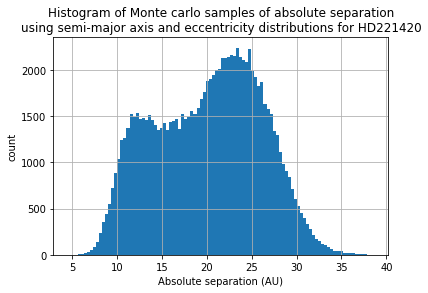

In [136]:
pd.DataFrame(r)[0].hist(bins=100)
plt.xlabel('Absolute separation (AU)')
plt.ylabel('count')
plt.title('Histogram of Monte carlo samples of absolute separation\nusing semi-major axis and eccentricity distributions for HD221420')
plt.savefig('AbsoluteSeparationHistogramHD221420')

In [137]:
r.mean()

20.11097774742691

In [96]:
20/14

1.4285714285714286

In [95]:
np.sqrt(48/27)

1.3333333333333333

In [6]:
def compute_mass(row):
    dic = {}
    if row['sep_type']=='a':
        dic['mass/r2'] = row['aTotal'].to(u.AU/u.second**2)/G
        for i in ['','_max','_min']:
            dic['mass%s'%i] = dic['mass/r2']*row['r_ab%s'%i]**2
            dic['mass%s_err'%i] = row['r_ab%s'%i]*np.sqrt(
                4*(row['aTotal'].to(u.AU/u.second**2)*row['r_ab%s_err'%i])**2 + 
                1*(row['r_ab%s'%i]*row['aTotal_err'].to(u.AU/u.second**2))**2)/G
        
        
        
    elif row['sep_type']=='proj_sep':
        dic['mass/r2'] = ((row['acc_astrom'].to(u.AU/u.second**2)**2 +
                           row['aRV'].to(u.AU/u.second**2)**2)**(3/2)
                         ) / (G*row['acc_astrom'].to(u.AU/u.second**2)**2)
        for i in ['','_max','_min']:
            dic['mass%s'%i] = dic['mass/r2']*row['a']**2
            dic['mass%s_err'%i] = np.sqrt( 
                (4*row['a_er_plus']**2/row['a']**2 + 
                 9*row['aRV']**2*row['aRV_Err']**2/
                 (row['aRV']**2+row['acc_astrom']**2)**2+
                 (3*row['acc_astrom']*row['acc_astrom_error']/
                  (row['aRV']**2+row['acc_astrom']**2)- 
                  2*row['acc_astrom_error']/row['acc_astrom'])**2
                )*dic['mass%s'%i]**2)
    return pd.Series(dic)

In [7]:
catalog = catalog.join(catalog.apply(compute_mass,axis=1))

In [8]:
catalog = catalog [['hip_id', 'hd_id','mass','mass_err' ,'mass_max', 'mass_max_err',
                    'mass_min', 'mass_min_err', 
                    'c_msini_jup','c_msini_er_jup',
                    'aTotal','aTotal_err','acc_astrom', 'acc_astrom_error',
                    'aRV','aRV_Err','a','a_er_plus', 'a_er_min','ecc','ecc_er',
                    'r_ab','r_ab_err','r_ab_max','r_ab_max_err','r_ab_min','r_ab_min_err',
                    'sep_source','sep_type','reftime','reduced ChiSq','RVfit']]
catalog.T

,0,1,2,3,4,5,6,7,8,9,10
hip_id,10278,30480,40118,42030,52472,79578,85653,110649,113789,114699,116250
hd_id,HD13724,HD45701,HD68017,HD72659,HD92987,HD145825,HD159062,HD212330,HD217850,HD219077,HD221420
mass,35.218803432134315 jupiterMass,1115.4768127280322 jupiterMass,126.9591274704211 jupiterMass,9.483127759738265 jupiterMass,139.03020715970354 jupiterMass,55.74720473966549 jupiterMass,693.8428650792404 jupiterMass,719.120771546353 jupiterMass,87.31958789905765 jupiterMass,22.02172955624681 jupiterMass,48.33945323186355 jupiterMass
mass_err,1.3094767377694423 jupiterMass,5.766137858928779 jupiterMass,3.42278508484843 jupiterMass,5.819784547106534 jupiterMass,0.9230364050982872 jupiterMass,2.383758749956718 jupiterMass,16.847898510629182 jupiterMass,27.504186574168948 jupiterMass,2.929024293776559 jupiterMass,0.8094021164135634 jupiterMass,3.129903939975925 jupiterMass
mass_max,57.187912832443686 jupiterMass,1491.0800039737096 jupiterMass,126.9591274704211 jupiterMass,13.42261154199364 jupiterMass,204.3332318933277 jupiterMass,89.60976274523011 jupiterMass,693.8428650792404 jupiterMass,1011.1770029969073 jupiterMass,162.92056456276458 jupiterMass,41.053971597662425 jupiterMass,81.93770019217654 jupiterMass
mass_max_err,25.26937451212171 jupiterMass,77.27402445851642 jupiterMass,3.42278508484843 jupiterMass,8.27610829564233 jupiterMass,27.408208387259943 jupiterMass,6.314646858043005 jupiterMass,16.847898510629182 jupiterMass,72.46451397590468 jupiterMass,17.96505191669617 jupiterMass,2.771806518890963 jupiterMass,21.824398333195806 jupiterMass
mass_min,13.873387630771033 jupiterMass,750.3871829479789 jupiterMass,126.9591274704211 jupiterMass,5.486641267232552 jupiterMass,73.55996348159798 jupiterMass,21.445394574673806 jupiterMass,693.8428650792404 jupiterMass,427.4392304600526 jupiterMass,2.969639204647485 jupiterMass,0.7069140704251367 jupiterMass,13.669828577984626 jupiterMass
mass_min_err,6.958597412437918 jupiterMass,39.22089610694058 jupiterMass,3.42278508484843 jupiterMass,3.3984808901311787 jupiterMass,10.93254484622033 jupiterMass,1.5957382647062626 jupiterMass,16.847898510629182 jupiterMass,31.333547151097534 jupiterMass,0.330814250821994 jupiterMass,0.05349718087853239 jupiterMass,4.2290703448349065 jupiterMass
c_msini_jup,26.77 jupiterMass,1034.0 jupiterMass,129.0 jupiterMass,3.85 jupiterMass,17.9 jupiterMass,108.0 jupiterMass,675.67976 jupiterMass,673.0 jupiterMass,21.6 jupiterMass,13.4 jupiterMass,9.7 jupiterMass
c_msini_er_jup,4.4 jupiterMass,87.0 jupiterMass,3.0 jupiterMass,0.23 jupiterMass,2.4 jupiterMass,6.2 jupiterMass,17.808614 jupiterMass,33.0 jupiterMass,2.6 jupiterMass,0.78 jupiterMass,1.1 jupiterMass


In [9]:
catalogCpy = catalog.copy()
for i in ['mass', 'mass_err', 'mass_max', 'mass_max_err',
       'mass_min', 'mass_min_err', 'c_msini_jup', 'c_msini_er_jup', 'aTotal',
       'aTotal_err', 'acc_astrom', 'acc_astrom_error', 'aRV', 'aRV_Err', 'a',
       'a_er_plus', 'a_er_min', 'r_ab', 'r_ab_err',
       'r_ab_max', 'r_ab_max_err', 'r_ab_min', 'r_ab_min_err']:
    catalogCpy[i] = np.around(catalogCpy[i].map(lambda x: x.value),decimals=3)
catalogCpy.T

,0,1,2,3,4,5,6,7,8,9,10
hip_id,10278,30480,40118,42030,52472,79578,85653,110649,113789,114699,116250
hd_id,HD13724,HD45701,HD68017,HD72659,HD92987,HD145825,HD159062,HD212330,HD217850,HD219077,HD221420
mass,35.219,1115.48,126.959,9.483,139.03,55.747,693.843,719.121,87.32,22.022,48.339
mass_err,1.309,5.766,3.423,5.82,0.923,2.384,16.848,27.504,2.929,0.809,3.13
mass_max,57.188,1491.08,126.959,13.423,204.333,89.61,693.843,1011.18,162.921,41.054,81.938
mass_max_err,25.269,77.274,3.423,8.276,27.408,6.315,16.848,72.465,17.965,2.772,21.824
mass_min,13.873,750.387,126.959,5.487,73.56,21.445,693.843,427.439,2.97,0.707,13.67
mass_min_err,6.959,39.221,3.423,3.398,10.933,1.596,16.848,31.334,0.331,0.053,4.229
c_msini_jup,26.77,1034,129,3.85,17.9,108,675.68,673,21.6,13.4,9.7
c_msini_er_jup,4.4,87,3,0.23,2.4,6.2,17.809,33,2.6,0.78,1.1


In [10]:
catalog['aRV_Err_Pct'] = (catalog['aRV_Err']/catalog['aRV']).abs().astype(float)
catalog['acc_astrom_error_Pct'] = (catalog['acc_astrom_error']/catalog['acc_astrom']
                                  ).abs().astype(float)
catalog['aTotal_err_Pct'] = (catalog['aTotal_err']/catalog['aTotal']
                            ).abs().astype(float)
catalog['a_err_Pct'] = (catalog['a_er_plus']/catalog['a']).abs().astype(float)
catalog['ecc_err_Pct'] = (catalog['ecc_er']/catalog['ecc']).abs().astype(float)
catalog['r_ab_err_Pct'] = (catalog['r_ab_err']/catalog['r_ab']).abs().astype(float)
catalog['r_ab_max_err_Pct'] = (catalog['r_ab_max_err']/catalog['r_ab_max']
                              ).abs().astype(float)
catalog['r_ab_min_err_Pct'] = (catalog['r_ab_min_err']/catalog['r_ab_min']
                              ).abs().astype(float)
catalog['mass_err_Pct'] = (catalog['mass_err']/catalog['mass']
                              ).abs().astype(float)
catalog['mass_max_err_Pct'] = (catalog['mass_max_err']/catalog['mass_max']
                              ).abs().astype(float)
catalog['mass_min_err_Pct'] = (catalog['mass_min_err']/catalog['mass_min']
                              ).abs().astype(float)

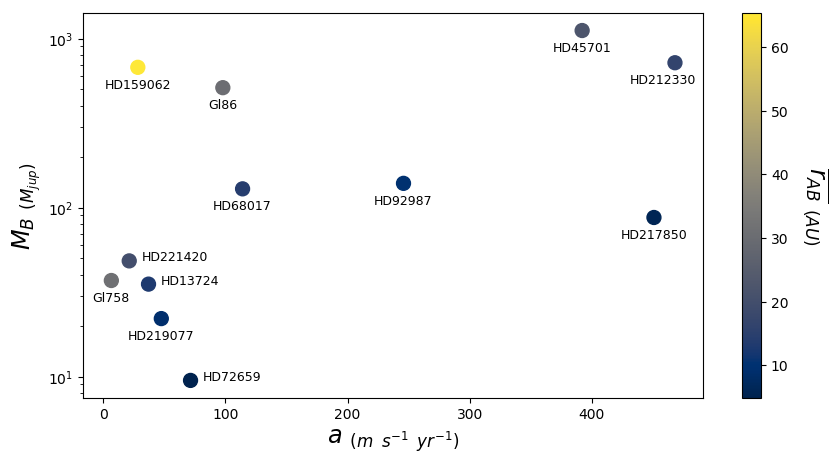

In [207]:
"""
plt.figure()
plt.scatter(catalog['acc_astrom'].map(lambda x: x.value),
            catalog['mass'].map(lambda x: x.value),
           s=100,
           c=catalog['r_ab'].map(lambda x: x.value))
           #yerr = 6*catalog['mass_err'].map(lambda x: x.value),fmt='o')
plt.xlabel('$a_t$ (m/s/yr)', fontsize='xx-large')
plt.ylabel('$M_2 (M_{jup})$', fontsize='xx-large')
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel('separation', fontsize='xx-large', labelpad=20, rotation=270) 
#plt.xscale('log')
plt.yscale('log')

plt.figure()
plt.scatter(catalog['aRV'].map(lambda x: abs(x.value)),
            catalog['mass'].map(lambda x: x.value),
           s=100,
           c=catalog['r_ab'].map(lambda x: x.value))
           #yerr = 6*catalog['mass_err'].map(lambda x: x.value),fmt='o')
plt.xlabel('$a_r$ (m/s/yr)', fontsize='xx-large')
plt.ylabel('$M_2 (M_{jup})$', fontsize='xx-large')
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel('separation', fontsize='xx-large', labelpad=20, rotation=270) 
#plt.xscale('log')
plt.yscale('log')
"""

plt.style.use('default')
catalogplt = catalog.copy()
catalogplt = catalogplt[~catalogplt.hd_id.isin(
    ['HD145825','HD68017','HD159062'])].reset_index(drop=True).copy()
catalogplt['aTotal'] = catalogplt['aTotal'].map(lambda x: x.value)
catalogplt['r_ab'] = catalogplt['r_ab'].map(lambda x: x.value)
catalogplt['mass'] = catalogplt['mass'].map(lambda x: x.value)
catalogplt = catalogplt[['hd_id','hip_id','aTotal','r_ab','mass']].append(
    pd.read_excel('known_masses.xlsx')
    [['hd_id','hip_id','aTotal','r_ab','mass']]).sort_values(by='hip_id').set_index('hd_id').copy()

plt.figure(figsize=(10,5))
plt.scatter(catalogplt['aTotal'],catalogplt['mass'],s=100,c=catalogplt['r_ab'],cmap='cividis')

for i in catalogplt.index:
    if i in ['HD221420','HD13724','HD72659','HD212330']:
        continue
    plt.text(catalogplt.loc[i,'aTotal'],catalogplt.loc[i,'mass']*0.75, i, ha='center', fontsize=9)
for i in ['HD221420','HD13724','HD72659']:
    plt.text(catalogplt.loc[i,'aTotal']+10,catalogplt.loc[i,'mass'], i,fontsize=9)
plt.text(catalogplt.loc['HD212330','aTotal']-10,catalogplt.loc['HD212330','mass']*0.75,'HD212330',ha='center',fontsize=9)

plt.xlabel('$a$ $_{(m}$ $_{s^{-1}}$ $_{yr^{-1})}$', fontsize='xx-large')
plt.ylabel('$M_B$ $_{(M_{jup})}$', fontsize='xx-large')
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel('$\overline{r_{AB}}$ $_{(AU)}$', fontsize='xx-large', labelpad=30, rotation=270) 

#plt.xscale('log')
plt.yscale('log')
plt.savefig('posterfig1.png', bbox_inches = "tight",dpi=500)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecatio

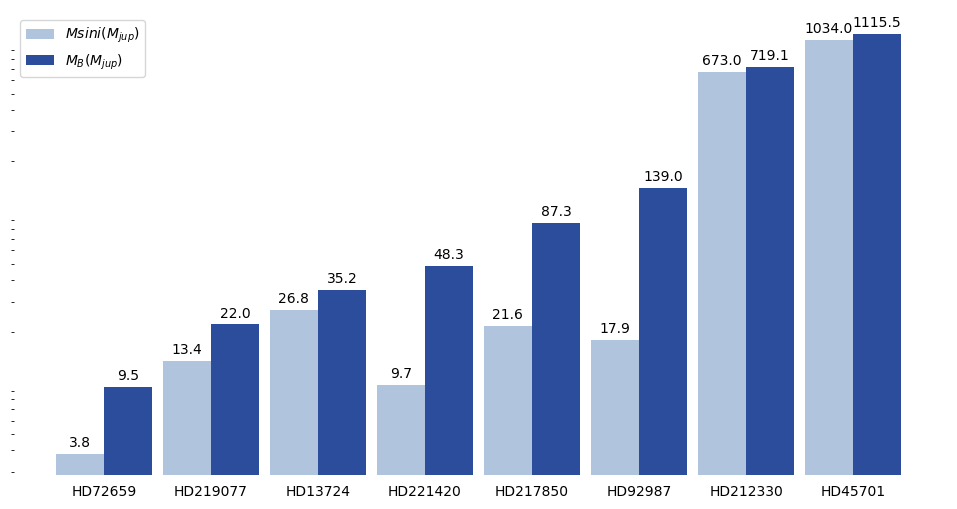

In [208]:
catalogplt = catalog.copy()
catalogplt = catalogplt.sort_values(by='mass')
catalogplt = catalogplt[~catalogplt.hd_id.isin(
    ['HD145825','HD68017','HD159062'])].copy()

ind = np.arange(len(catalogplt))  # the x locations for the groups
width = 0.45       # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind, np.around(catalogplt['c_msini_jup'].map(lambda x: x.value),decimals=1)
                , width, color='#B0C4DE')
rects2 = ax.bar(ind + width, np.around(catalogplt['mass'].map(
    lambda x: x.value),decimals=1), width, color='#2B4D9B')

# add some text for labels, title and axes ticks
#ax.set_ylabel('Masses')
ax.set_xticks(ind + width / 2)
#plt.xticks(rotation=70) #rotate x labels
ax.set_xticklabels(catalogplt.hd_id)
plt.yscale('log')
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='False', bottom='False', left='False', right='False', labelleft='False', labelbottom='True')


# direct label each bar with Y axis values
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

# add a legend
ax.legend((rects1[0], rects2[0]), ('$Msini (M_{jup})$',
                                   '$M_B (M_{jup})$'))

# save as a png file
plt.savefig('posterfig2.png', bbox_inches = "tight",dpi=500)

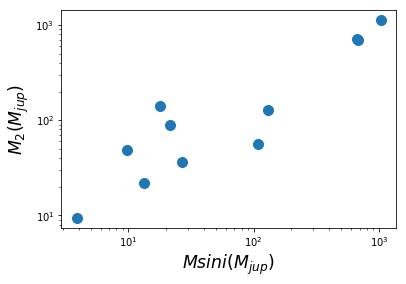

In [138]:
plt.figure()
plt.plot(catalog['c_msini_jup'].map(lambda x: x.value),
            catalog['mass'].map(lambda x: x.value),
            s=100)
           #c=catalog['r_ab'].map(lambda x: x.value))
           #yerr = 6*catalog['mass_err'].map(lambda x: x.value),fmt='o')
plt.xlabel('$Msini (M_{jup})$', fontsize='xx-large')
plt.ylabel('$M_2 (M_{jup})$', fontsize='xx-large')
#cbar1 = plt.colorbar()
#cbar1.ax.set_ylabel('separation', fontsize='xx-large', labelpad=20, rotation=270) 
plt.xscale('log')
plt.yscale('log')